In [1]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


In [2]:
import os

path = '/content/drive/MyDrive/Deep Learning/VCB_Stock_Predict'
os.chdir(path)

In [3]:
# Import necessary libs
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os.path
from os import path
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [ ]:
# Read train data (2009->2018)
dataset_train = pd.read_csv('vcb_2009_2018.csv')
training_set = dataset_train.iloc[:, 1:2].values
print(training_set.shape)
training_set

In [9]:
# Scale dat into (0,1)
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
print(training_set_scaled.shape)
training_set_scaled[:10]

(2374, 1)


array([[0.73417722],
       [0.74321881],
       [0.69801085],
       [0.66184448],
       [0.70705244],
       [0.67088608],
       [0.65280289],
       [0.62567812],
       [0.58047016],
       [0.53526221]])

In [10]:
# Create training data, X = 60 days time steps, y =  1 day time step
X_train = []
y_train = []
no_of_sample = len(training_set)
print(no_of_sample)

for i in range(60, no_of_sample):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape, y_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)

2374
(2314, 60) (2314,)
(2314, 60, 1)


In [12]:
# Build LSTM model
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Load file model if it existed
if path.exists("mymodel.h5"):
    regressor.load_weights("mymodel.h5")
else:
    # If not exist file model, train!
    regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)
    regressor.save("mymodel.h5")



Epoch 1/100
2314/2314 [==============================] - 11s 5ms/step - loss: 0.0136
Epoch 2/100
2314/2314 [==============================] - 10s 4ms/step - loss: 0.0042
Epoch 3/100
2314/2314 [==============================] - 10s 4ms/step - loss: 0.0040
Epoch 4/100
2314/2314 [==============================] - 10s 4ms/step - loss: 0.0038
Epoch 5/100
2314/2314 [==============================] - 10s 4ms/step - loss: 0.0037
Epoch 6/100
2314/2314 [==============================] - 10s 4ms/step - loss: 0.0029
Epoch 7/100
2314/2314 [==============================] - 10s 4ms/step - loss: 0.0030
Epoch 8/100
2314/2314 [==============================] - 10s 4ms/step - loss: 0.0033
Epoch 9/100
2314/2314 [==============================] - 10s 4ms/step - loss: 0.0027
Epoch 10/100
2314/2314 [==============================] - 10s 4ms/step - loss: 0.0025
Epoch 11/100
2314/2314 [==============================] - 10s 4ms/step - loss: 0.0026
Epoch 12/100
2314/2314 [==============================] - 10s 

In [13]:
# Load data from 1/1/2019 - 2/10/2019
dataset_test = pd.read_csv('vcb_2019.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

In [14]:
# Predict
dataset_total = pd.concat((dataset_train['CLOSE'], dataset_test['CLOSE']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
no_of_sample = len(inputs)

for i in range(60, no_of_sample):
    X_test.append(inputs[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

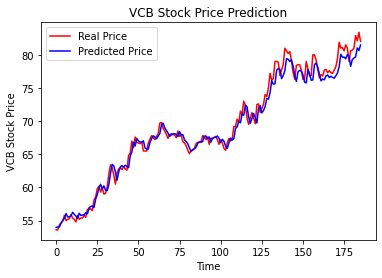

In [16]:
# Visualize predict and true values
plt.plot(real_stock_price, color = 'red', label = 'Real Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Price')
plt.title('VCB Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('VCB Stock Price')
plt.legend()
plt.show()

In [17]:
# Continue predict next days to 30/10
dataset_test = dataset_test['CLOSE'][len(dataset_test)-60:len(dataset_test)].to_numpy()
dataset_test = np.array(dataset_test)

inputs = dataset_test
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

In [18]:
i = 0
while i<28:
    X_test = []
    no_of_sample = len(dataset_test)

    # Get last data
    X_test.append(inputs[no_of_sample - 60:no_of_sample, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Predict data
    predicted_stock_price = regressor.predict(X_test)

    # Convert price from (0,1) into true price
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)

    # Add recent day
    dataset_test = np.append(dataset_test, predicted_stock_price[0], axis=0)
    inputs = dataset_test
    inputs = inputs.reshape(-1, 1)
    inputs = sc.transform(inputs)

    print('Stock price ' + str(i+3) + '/10/2019 of VCB : ', predicted_stock_price[0][0])
    i = i + 1

Stock price 3/10/2019 of VCB :  80.664635
Stock price 4/10/2019 of VCB :  79.601616
Stock price 5/10/2019 of VCB :  78.780304
Stock price 6/10/2019 of VCB :  78.09845
Stock price 7/10/2019 of VCB :  77.49116
Stock price 8/10/2019 of VCB :  76.93623
Stock price 9/10/2019 of VCB :  76.424416
Stock price 10/10/2019 of VCB :  75.949936
Stock price 11/10/2019 of VCB :  75.50848
Stock price 12/10/2019 of VCB :  75.09655
Stock price 13/10/2019 of VCB :  74.71135
Stock price 14/10/2019 of VCB :  74.35058
Stock price 15/10/2019 of VCB :  74.01238
Stock price 16/10/2019 of VCB :  73.69526
Stock price 17/10/2019 of VCB :  73.39796
Stock price 18/10/2019 of VCB :  73.11941
Stock price 19/10/2019 of VCB :  72.85864
Stock price 20/10/2019 of VCB :  72.61479
Stock price 21/10/2019 of VCB :  72.386986
Stock price 22/10/2019 of VCB :  72.17438
Stock price 23/10/2019 of VCB :  71.976135
Stock price 24/10/2019 of VCB :  71.791466
Stock price 25/10/2019 of VCB :  71.61955
Stock price 26/10/2019 of VCB :  